In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import numpy as np
from PIL import Image

In [8]:
# Preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [10]:
# Loading the Brain tumor Dataset
data_dir = 'C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset'  # Update with actual dataset path
train_dataset = datasets.ImageFolder(root=f"{data_dir}/training", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/testing", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Model Definition
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(train_dataset.classes))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)

In [12]:
# Initializing the Model
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [16]:
# Training the MLP model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct =0
    total =0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,predicted = torch.max(outputs,1)
        total +=labels.size(0)
        correct +=(predicted ==labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)} , Accuracy: {100*correct/total}")


Epoch 1/5, Loss: 0.9813000453251034 , Accuracy: 76.1204481792717
Epoch 2/5, Loss: 0.986947690308427 , Accuracy: 75.1750700280112
Epoch 3/5, Loss: 0.9826472684657773 , Accuracy: 75.64775910364146
Epoch 4/5, Loss: 0.9640084957943282 , Accuracy: 77.62605042016807
Epoch 5/5, Loss: 0.9666887495104827 , Accuracy: 77.38095238095238


In [17]:
# Evaluating the model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

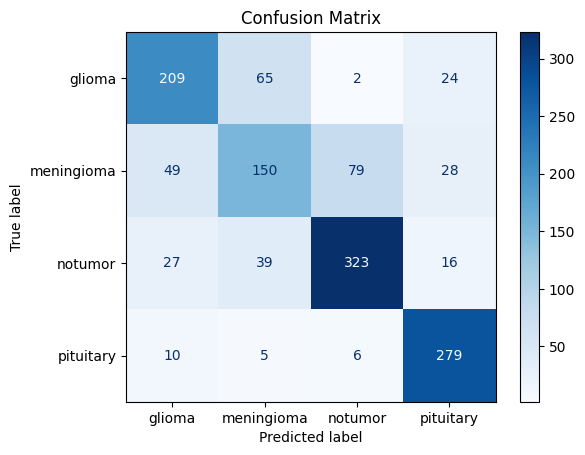

In [19]:
#Plotting the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(len(train_dataset.classes)))
cmd = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [20]:
def calculate_metrics(cm):
    precision = []
    recall = []
    f1_score = []

    for i in range(len(cm)):
        tp = cm[i, i]  
        fp = sum(cm[:, i]) - tp  
        fn = sum(cm[i, :]) - tp  

        if tp + fp == 0:
            precision.append(0)
        else:
            precision.append(tp / (tp + fp))

        if tp + fn == 0:
            recall.append(0)
        else:
            recall.append(tp / (tp + fn))

        if precision[-1] + recall[-1] == 0:
            f1_score.append(0)
        else:
            f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))

    return precision, recall, f1_score



def print_metrics_per_class(precision, recall, f1_score):
    print("Class-wise Metrics:")
    print(f"{'Class':<6} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    for i in range(len(precision)):
        print(f"{i:<6} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1_score[i]:<10.3f}")

precision, recall, f1_score = calculate_metrics(cm)
print_metrics_per_class(precision, recall, f1_score)


Class-wise Metrics:
Class  Precision  Recall     F1 Score  
0      0.708      0.697      0.703     
1      0.579      0.490      0.531     
2      0.788      0.798      0.793     
3      0.804      0.930      0.862     


In [23]:
# Testing by giving an image
input_path = 'C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset/Testing/glioma/Te-gl_0040.jpg'
try:
    image = Image.open(input_path).convert('L') 
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    print(f"Predicted class: {train_dataset.classes[predicted.item()]}")
except Exception as e:
    print(f"Error loading image: {e}")

Predicted class: glioma
